In [3]:
import sys
import os 
from subprocess import Popen
import glob
import fileinput
import shutil 
import csv
import math

from pathlib import Path
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


# --- INPUTS ---

In [4]:
## INPUTS ##

results_dir = r'D:\ituran\NYCviews\BINS_test_2'

# Outdoor ray % threshold for each point (0-100%)
viewThreshold = 20


# --- FUNCTIONS ---

In [62]:
# Get a list of the immediate subdirectories in a folder
def get_immediate_subdirs(a_dir):
    # a_dir: the path for results directory
    
    namesList = [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]
    return(namesList)

# Reading .dat csv file into df 
def read_dat_csv(csvfile): 
    # csvfile: path of of the .dat csv results file 
    
    data = pd.read_csv(csvfile, sep="\t", header=None, index_col=False)
    data = data.drop(data.columns[-1], axis=1)
    data.columns = ["x", "y", "z", "mat", "dist", "destination"]
    #print(data.head())
    #print(data.shape)
    
    return(data)

# Encode the materials in the df using one hot encoding (one column per material)
def encode_materials(data): 
    # **note: create a copy of the original material column for reference 
    # data: the data df from read_dat_csv

    data['orig_mat']=data['mat']
    data = pd.get_dummies(data, columns=['mat'])
    
    #print('HEAD', data.head())
    print('SHAPE', data.shape)
    
    return(data)

# Check that all materials are accounted for and output a dictionary with list of all materials
def view_material_check(data_encoded): 
    
    # data_encoded: output of encode_materials --> data with material hot coded

    # Filter points by how many rays reach outside / inside (based on material names -- UPDATE IF NEEDED)
    # Create a list of all column names for interior and exterior materials
    viewColumns = data_encoded.filter(regex='view|Outside|sky').columns
    interiorMats = data_encoded.filter(regex='Generic').columns
    allMaterials = data_encoded.filter(regex='^mat_').columns
        
    # Check that all materials accounted for in filtering
    if len(viewColumns) + len(interiorMats) != len(allMaterials): 
        print('Material error!')
        print('outside:', viewColumns)
        print('inside:', interiorMats)
        print('all:', allMaterials)
        sys.exit()    
    else: 
        print('STEP 3 (view_output_analysis) CHECK: All materials accounted for in dataframe.')
        #print('Inside materials:', '\n', interiorMats, '\n')
        #print('Outside materials:', '\n', viewColumns, '\n')

    # Make a dictionary of the materials for other functions
    matDict = {}
    matDict['outside'] = viewColumns
    matDict['inside'] = interiorMats
    matDict['all'] = allMaterials
    #print(matDict)
    
    return(matDict)




# Visualize the view distribution by floor 
def view_floor_visualize(allRaySums):
    
    # allRaySums: output df from view_output_analysis

    # PLOT 1: Plot all floors together as subplots in one row
    grouped = allRaySums.groupby('z')
    rowlength = grouped.ngroups

    # Set up figure with # subplots according to BIN group size (axs is a numpy array of axes)
    fig, axs = plt.subplots(nrows=1, ncols=rowlength, sharey=True, figsize=(4*rowlength, 4))

    if rowlength > 1: 
        # Flatten collapses the np array into one dimension 
        targets = zip(grouped.groups.keys(), axs.flatten())

        # Create subplot for each floor using the group key
        for i, (key, ax) in enumerate(targets): 
            #print(grouped.get_group(key))
            im = ax.scatter(grouped.get_group(key)['x'], grouped.get_group(key)['y'], 
                       c=grouped.get_group(key)['outside_0-100'], 
                       s=grouped.get_group(key)['outside_0-100'])

            ax.set_title(('z=%d'%key))
            ax.axis('equal')  
            ax.set_xticks([])
            ax.set_yticks([])
            
    else: 
        im = axs.scatter(allRaySums['x'], allRaySums['y'], 
                        c=allRaySums['outside_0-100'], 
                        s=allRaySums['outside_0-100'])
        axs.set_title(('z=%d'%list(grouped.groups)[0]))
        axs.axis('equal')  
        axs.set_xticks([])
        axs.set_yticks([])

    fig.colorbar(im)
    plt.show()

    # PLOT 2: Plot all floors together in 3D 
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    im = ax.scatter(allRaySums['x'], allRaySums['y'], allRaySums['z'], c=allRaySums['outside_0-100'])

    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title('BIN: ' + filename)
    fig.colorbar(im)
    plt.show()

    
def view_threshold_count(allRaySums, viewThreshold): 
    
    # allRaySums: output df from view_output_analysis
    # viewThreshold: outdoor ray % threshold for each point (0-100%) 
   
    # Boolean variable to filter by threshold (points where the # outdoor rays greater than threshold)
    thresholdpts = allRaySums['outside_0-100'] >= viewThreshold
    
    # filter rows by boolean variable
    viewPoints = allRaySums[thresholdpts] # points with view
    noViewPoints = allRaySums[~thresholdpts] # points without view (the majority)
    
    # Calculate % of total points per FLOOR with a view
    viewFloors = viewPoints.groupby(['z']).outside.count()
    noViewFloors = noViewPoints.groupby(['z']).outside.count()
    allRaysbyFloor = allRaySums.groupby(['z']).outside.count()

    print('>>>>>>>>>>>>>>>>>>>>>>')
    print('>> Points on floor with minimium view AND total number of points per floor:')
    print(viewFloors, allRaysbyFloor)
    
    # Percentage of points with view per floor 
    # use the noViewFloors to retain all floors in sample (some floors may not have exterior views)
    viewFloorPercent = (allRaysbyFloor-noViewFloors)*100/allRaysbyFloor
        
    print('>>>>>>>>>>>>>>>>>>>>>>')
    print('>> % of floor points with minimum view:')
    print(viewFloorPercent)  


In [166]:
# Calculate the total external rays for each point on each floor
def view_distance_analysis(data_encoded, matDict): 
    
    # data_encoded: output of encode_materials --> data with material hot coded
    # matDict: dictionary of materials from view_material_check
    
    #########################
    ### EVALUTE OUTSIDE RAY DISTANCES ###
    #########################
    
    # Create column that notes if the ray is outside or in (True == outside)
    data_encoded['outside_ray'] = (data_encoded[matDict['outside']] == 1).any(1)
    #print(data_encoded.head())

    # Plot histogram of outside ray % by floor
    print('\n')
    print('>>>>>>>>>>>>>>>>>>>>>>')
    print('>> Distribution: distance of outside rays by material')
    print('>>>>>>>>>>>>>>>>>>>>>>')
    
    outside_data_encoded = data_encoded.loc[data_encoded['outside_ray'] == True]
    inside_data_encoded = data_encoded.loc[data_encoded['outside_ray'] == False]
    
    # Set up histogram subplots
    colLength = len(matDict['outside'])
    fig, axs = plt.subplots(nrows=1, ncols=colLength, figsize = (8*colLength, 6))
    
    if colLength >1: 
        # If more than one floor
        targets = zip(matDict['outside'], axs.flatten())
        for i, (key, ax) in enumerate(targets): 
            # i = index; key = material name; ax = axis
            for (x,d) in outside_data_encoded.groupby('z'):
                plotD = d.loc[d['orig_mat'] == key[4:]]
                im = ax.hist(plotD['dist'], alpha = 0.6, label = str(x), bins=300)
            ax.set_title(key[4:])
            ax.legend()
    else: 
        # only one floor
        for (x,d) in outside_data_encoded.groupby('z'):
            plotD = d.loc[d['orig_mat'] == matDict['outside'][0]]
            im = axs.hist(plotD['dist'], alpha = 0.6, label = str(x), bins=300)
        axs.set_title(matDict['outside'][0])
        axs.legend()
    plt.show()

#     # Check the sky rays 
#     sky_rays = outside_data_encoded.loc[outside_data_encoded['mat_sky_mat']== 1]
#     print('Check the sky rays (b/c not showing up in histogram)')
#     print(sky_rays.groupby('z').agg({'dist': ['mean', 'min', 'max', 'count']}))
            
    #########################
    ### SEPARATE BY FLOOR ###
    #########################
    
    # Sum up total rays hitting each material type and create new column with all outside ray counts
    allRaySums = data_encoded.groupby(['z','x', 'y'])[matDict['all']].apply(lambda x : x.astype(int).sum())
    allRaySums['outside'] = allRaySums[matDict['outside']].sum(axis=1)
    allRaySums['inside'] = allRaySums[matDict['inside']].sum(axis=1)
    allRaySums['total'] = allRaySums[matDict['all']].sum(axis=1)
        
    print('\n')
    print('>>>>>>>>>>>>>>>>>>>>>>')
    print('total number of rays per floor reaching the outside by material')
    print('>>>>>>>>>>>>>>>>>>>>>>')
    print(allRaySums.groupby('z')[matDict['outside']].sum())
    #print(allRaySums.groupby('z')['outside'].sum())
    print('>>>>>>>>>>>>>>>>>>>>>>')
    print('distance of each ray by outside material')
    print('>>>>>>>>>>>>>>>>>>>>>>')
    print(outside_data_encoded.groupby(['z', 'orig_mat']).agg({'dist': ['mean', 'min', 'max', 'count']}))
    
    #########################
    ### % OUTSIDE RAYS BY FLOOR ###
    #########################
    # Calculate total % of rays reaching outside
    allRaySums['outside_0-100'] = allRaySums['outside']*100 / allRaySums['total']
    
    # Get breakdown of outdoor material totals
    for mat in matDict['outside']: 
        allRaySums['tot_' + mat] = (allRaySums[mat]*100/allRaySums['outside'])
    
    print('\n')
    print('>>>>>>>>>>>>>>>>>>>>>>')
    print('>> Average % (mean for each point NOT total % across the floor) of each outside object hit for all points on the floor')
    print('>>>>>>>>>>>>>>>>>>>>>>')
    print(allRaySums.groupby('z')['tot_' + matDict['outside']].mean())
    
    # Summary Statistics by Floor 
    print('\n')
    print('>>>>>>>>>>>>>>>>>>>>>>')
    print('>> Summary Statistics per Floor (outside rays per point (outside_0-100))')
    print('>> Based on these determine the threshold for next step')
    print('>>>>>>>>>>>>>>>>>>>>>>')

    print(allRaySums.groupby('z').agg({'outside_0-100': ['mean', 'min', 'max', 'count']}))
    print('\n')
    
    # Reset the index so that multiindex levels are columns (to plot)
    allRaySums.reset_index(inplace=True)
    
#     # Plot histogram of outside ray % by floor
#     print('>>>>>>>>>>>>>>>>>>>>>>')
#     print('>> Floor-by-floor histograms: % of outside rays per point throughout floorplate')
#     print('>>>>>>>>>>>>>>>>>>>>>>')
#     pd.DataFrame(allRaySums['outside_0-100']).hist(by=allRaySums['z'], bins=100)
#     plt.show()

    
    return(allRaySums) 

# Single BIN Test

In [160]:
resultsTest = r'D:\ituran\NYCviews\BINS_test_2'
filename = '1034235'
#filename = '1034237'

resultsPath = resultsTest + '\\' + filename + '\\' + filename + '_out.dat'

print('START: ' + filename)
print(resultsPath)

# workflow for one BIN
df_data = read_dat_csv(resultsPath)
print('step 1: done', '\n')

df_data2 = encode_materials(df_data)
print('step 2: done', '\n')
    

START: 1034235
D:\ituran\NYCviews\BINS_test_2\1034235\1034235_out.dat
step 1: done 

SHAPE (6600096, 15)
step 2: done 



STEP 3 (view_output_analysis) CHECK: All materials accounted for in dataframe.


>>>>>>>>>>>>>>>>>>>>>>
>> Distribution: distance of outside rays by material
>>>>>>>>>>>>>>>>>>>>>>


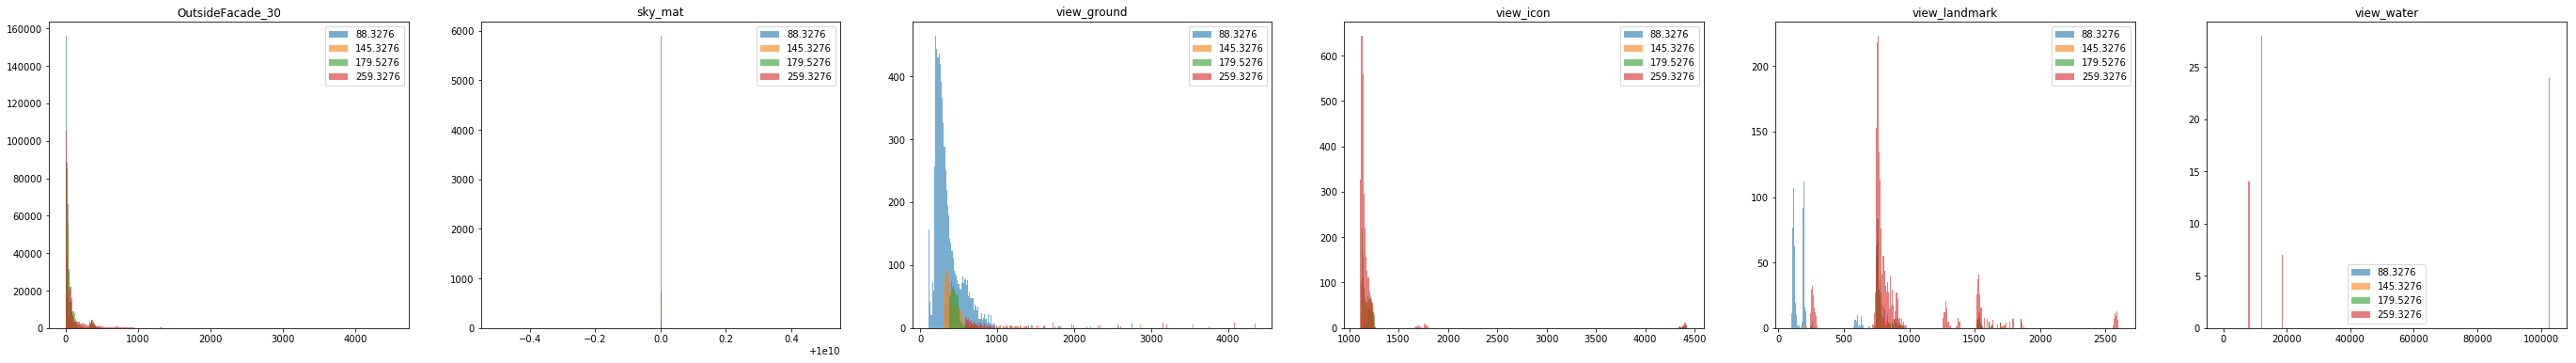



>>>>>>>>>>>>>>>>>>>>>>
total number of rays per floor reaching the outside by material
>>>>>>>>>>>>>>>>>>>>>>
          mat_OutsideFacade_30  mat_sky_mat  mat_view_ground  mat_view_icon  \
z                                                                             
88.3276                 417625           72             7135            268   
145.3276                293252          182             1685            692   
179.5276                348519          745              885           1106   
259.3276                288454         5894              366           2834   

          mat_view_landmark  mat_view_water  
z                                            
88.3276                1196               0  
145.3276                514               0  
179.5276                556               0  
259.3276               1945              73  
>>>>>>>>>>>>>>>>>>>>>>
distance of each ray by outside material
>>>>>>>>>>>>>>>>>>>>>>
                                   dist           

In [167]:
materialDict = view_material_check(df_data2)

df_data3 = view_distance_analysis(df_data2, materialDict)
print('step 3: done', '\n')

#view_floor_visualize(df_data3)

#df_data4= view_threshold_count(df_data3, viewThreshold)
print('step 4: done', '\n')

print('END: ' + filename)


# Loop through BINS

START: 1034228
D:\ituran\NYCviews\BINS_test_2\1034228\1034228_out.dat
step 1: done
SHAPE (6752876, 16)
step 2: done 

STEP 3 (view_output_analysis) CHECK: All materials accounted for in dataframe.


>>>>>>>>>>>>>>>>>>>>>>
>> Distribution: distance of outside rays by material
>>>>>>>>>>>>>>>>>>>>>>


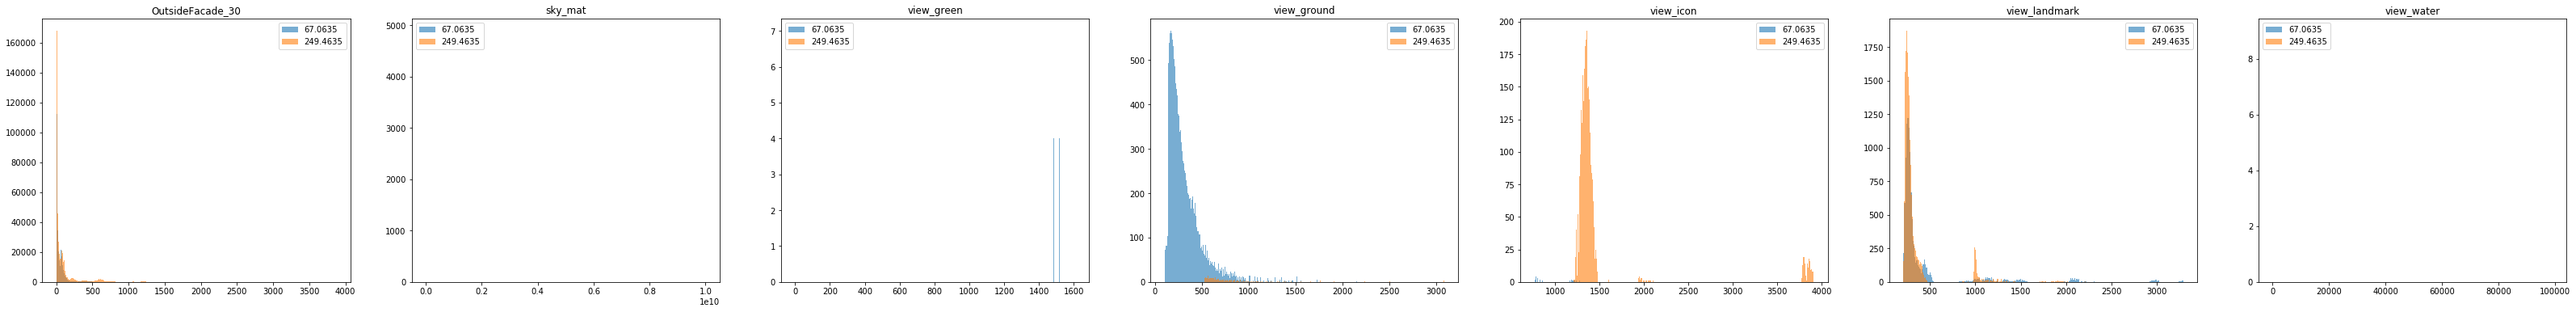



>>>>>>>>>>>>>>>>>>>>>>
total number of rays per floor reaching the outside by material
>>>>>>>>>>>>>>>>>>>>>>
          mat_OutsideFacade_30  mat_sky_mat  mat_view_green  mat_view_ground  \
z                                                                              
67.0635                 278255            0              36            18198   
249.4635                410951         4894               0              299   

          mat_view_icon  mat_view_landmark  mat_view_water  
z                                                           
67.0635             102              12370               0  
249.4635           2772              23165               9  
>>>>>>>>>>>>>>>>>>>>>>
distance of each ray by outside material
>>>>>>>>>>>>>>>>>>>>>>
                                   dist                                    
                                   mean           min           max   count
z        orig_mat                                                          
67.0635 

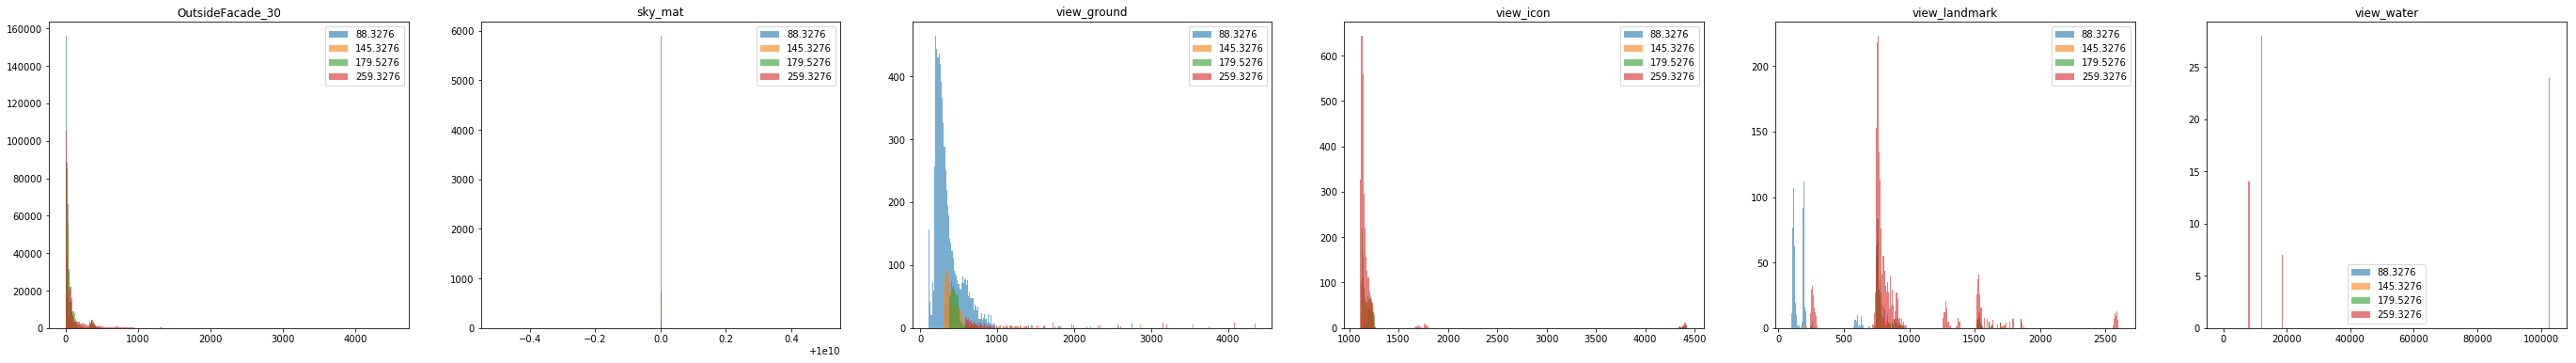



>>>>>>>>>>>>>>>>>>>>>>
total number of rays per floor reaching the outside by material
>>>>>>>>>>>>>>>>>>>>>>
          mat_OutsideFacade_30  mat_sky_mat  mat_view_ground  mat_view_icon  \
z                                                                             
88.3276                 417625           72             7135            268   
145.3276                293252          182             1685            692   
179.5276                348519          745              885           1106   
259.3276                288454         5894              366           2834   

          mat_view_landmark  mat_view_water  
z                                            
88.3276                1196               0  
145.3276                514               0  
179.5276                556               0  
259.3276               1945              73  
>>>>>>>>>>>>>>>>>>>>>>
distance of each ray by outside material
>>>>>>>>>>>>>>>>>>>>>>
                                   dist           

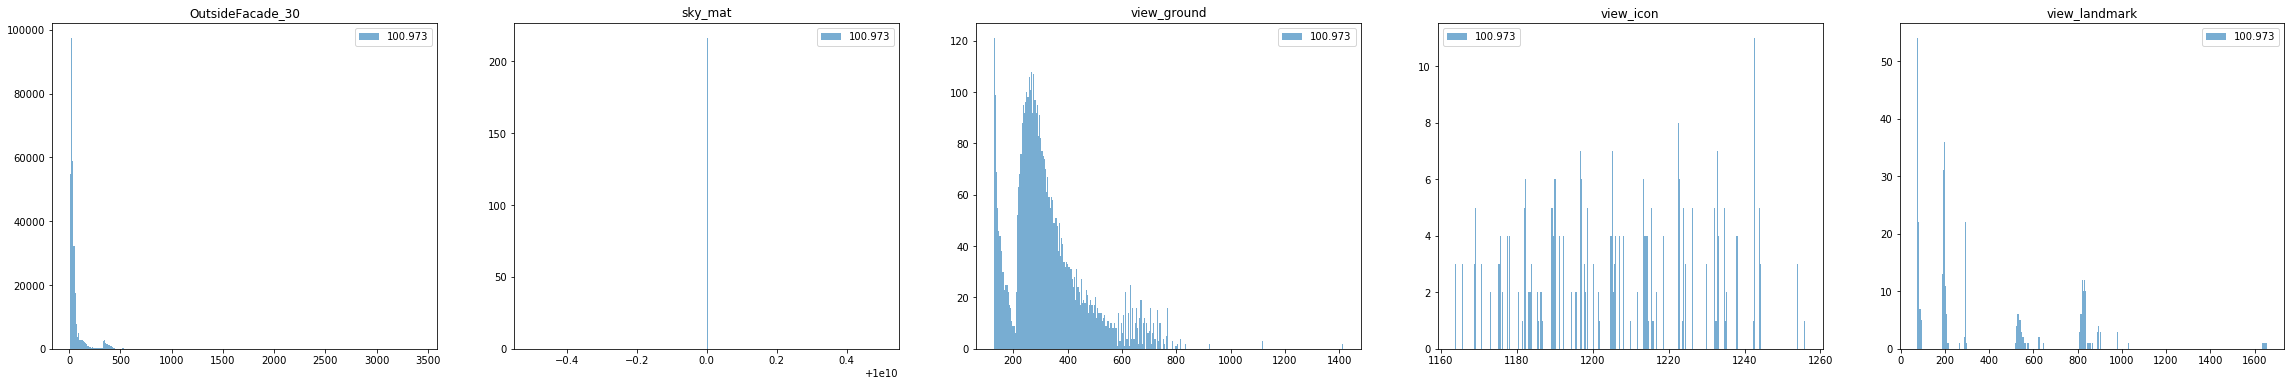



>>>>>>>>>>>>>>>>>>>>>>
total number of rays per floor reaching the outside by material
>>>>>>>>>>>>>>>>>>>>>>
         mat_OutsideFacade_30  mat_sky_mat  mat_view_ground  mat_view_icon  \
z                                                                            
100.973                313878          216             4895            272   

         mat_view_landmark  
z                           
100.973                321  
>>>>>>>>>>>>>>>>>>>>>>
distance of each ray by outside material
>>>>>>>>>>>>>>>>>>>>>>
                                  dist                                    
                                  mean           min           max   count
z       orig_mat                                                          
100.973 OutsideFacade_30  5.827246e+01  7.174817e+00  3.421882e+03  313878
        sky_mat           1.000000e+10  1.000000e+10  1.000000e+10     216
        view_ground       3.290615e+02  1.272866e+02  1.414708e+03    4895
        view_icon         1.2

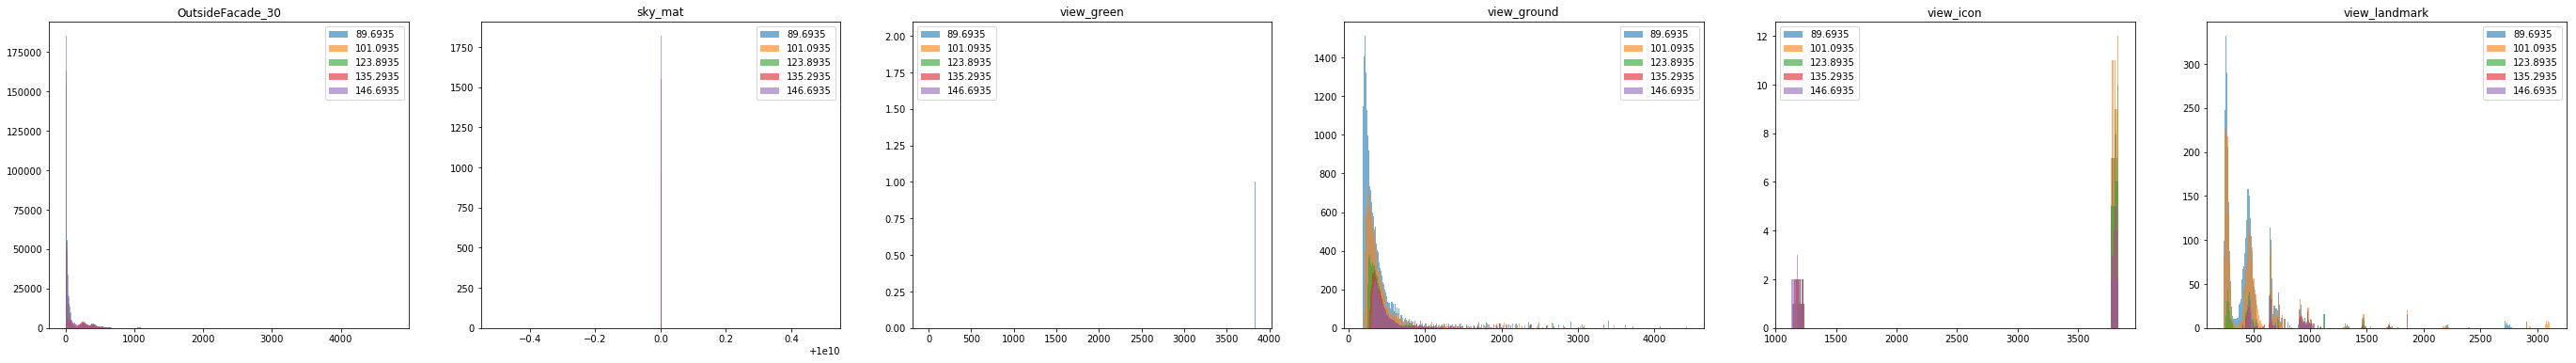



>>>>>>>>>>>>>>>>>>>>>>
total number of rays per floor reaching the outside by material
>>>>>>>>>>>>>>>>>>>>>>
          mat_OutsideFacade_30  mat_sky_mat  mat_view_green  mat_view_ground  \
z                                                                              
89.6935                 334723          796              15            21443   
101.0935                152565          963               0            13239   
123.8935                364700         1297               0             6245   
135.2935                158705         1549               0             4448   
146.6935                395681         1819               0             3382   

          mat_view_icon  mat_view_landmark  
z                                           
89.6935              57               3817  
101.0935             75               2746  
123.8935             60                933  
135.2935             40                610  
146.6935             43                517  
>>>>>>>>>>>>

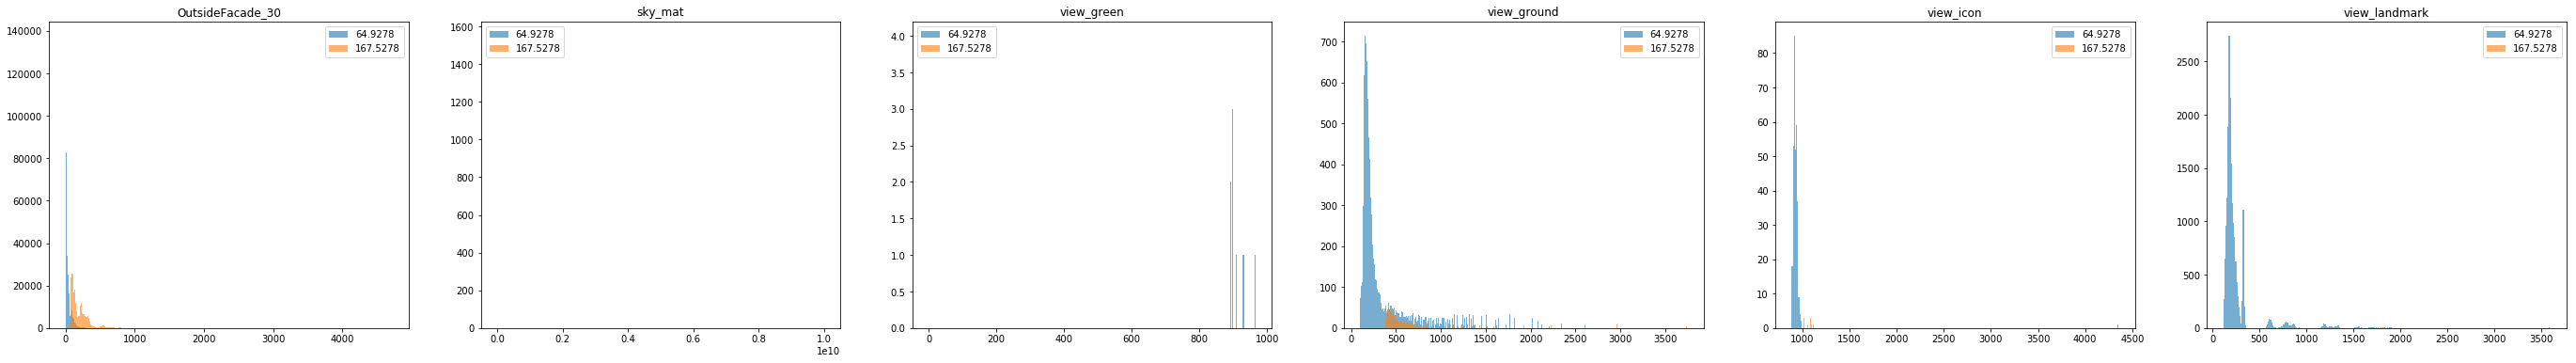



>>>>>>>>>>>>>>>>>>>>>>
total number of rays per floor reaching the outside by material
>>>>>>>>>>>>>>>>>>>>>>
          mat_OutsideFacade_30  mat_sky_mat  mat_view_green  mat_view_ground  \
z                                                                              
64.9278                 445730            0              93            10646   
167.5278                199144         1550               0              807   

          mat_view_icon  mat_view_landmark  
z                                           
64.9278             320              19075  
167.5278            186                 50  
>>>>>>>>>>>>>>>>>>>>>>
distance of each ray by outside material
>>>>>>>>>>>>>>>>>>>>>>
                                   dist                                    
                                   mean           min           max   count
z        orig_mat                                                          
64.9278  OutsideFacade_30  3.386596e+01  1.655176e+00  2.228936e+03  445

In [168]:
# Get list of all BINS in results directory list 
dir_list = get_immediate_subdirs(results_dir)

# loop through all BIN results
for filename in dir_list: 
    resultsPath = results_dir + '\\' + filename + '\\' + filename + '_out.dat'
    print('START: ' + filename)
    print(resultsPath)

    # workflow for one BIN
    df_data = read_dat_csv(resultsPath)
    print('step 1: done')

    df_data2 = encode_materials(df_data)
    print('step 2: done', '\n')

    materialDict = view_material_check(df_data2)

    df_data3 = view_distance_analysis(df_data2, materialDict)
    print('step 3: done', '\n')
    
    # Visualize the results
    #%matplotlib notebook     #Enable interactivity in the jupyter notebook 
    #view_floor_visualize(df_data3)
    
    #df_data4= view_threshold_count(df_data3, viewThreshold)
    print('step 4: done')
    
    print('END: ' + filename)